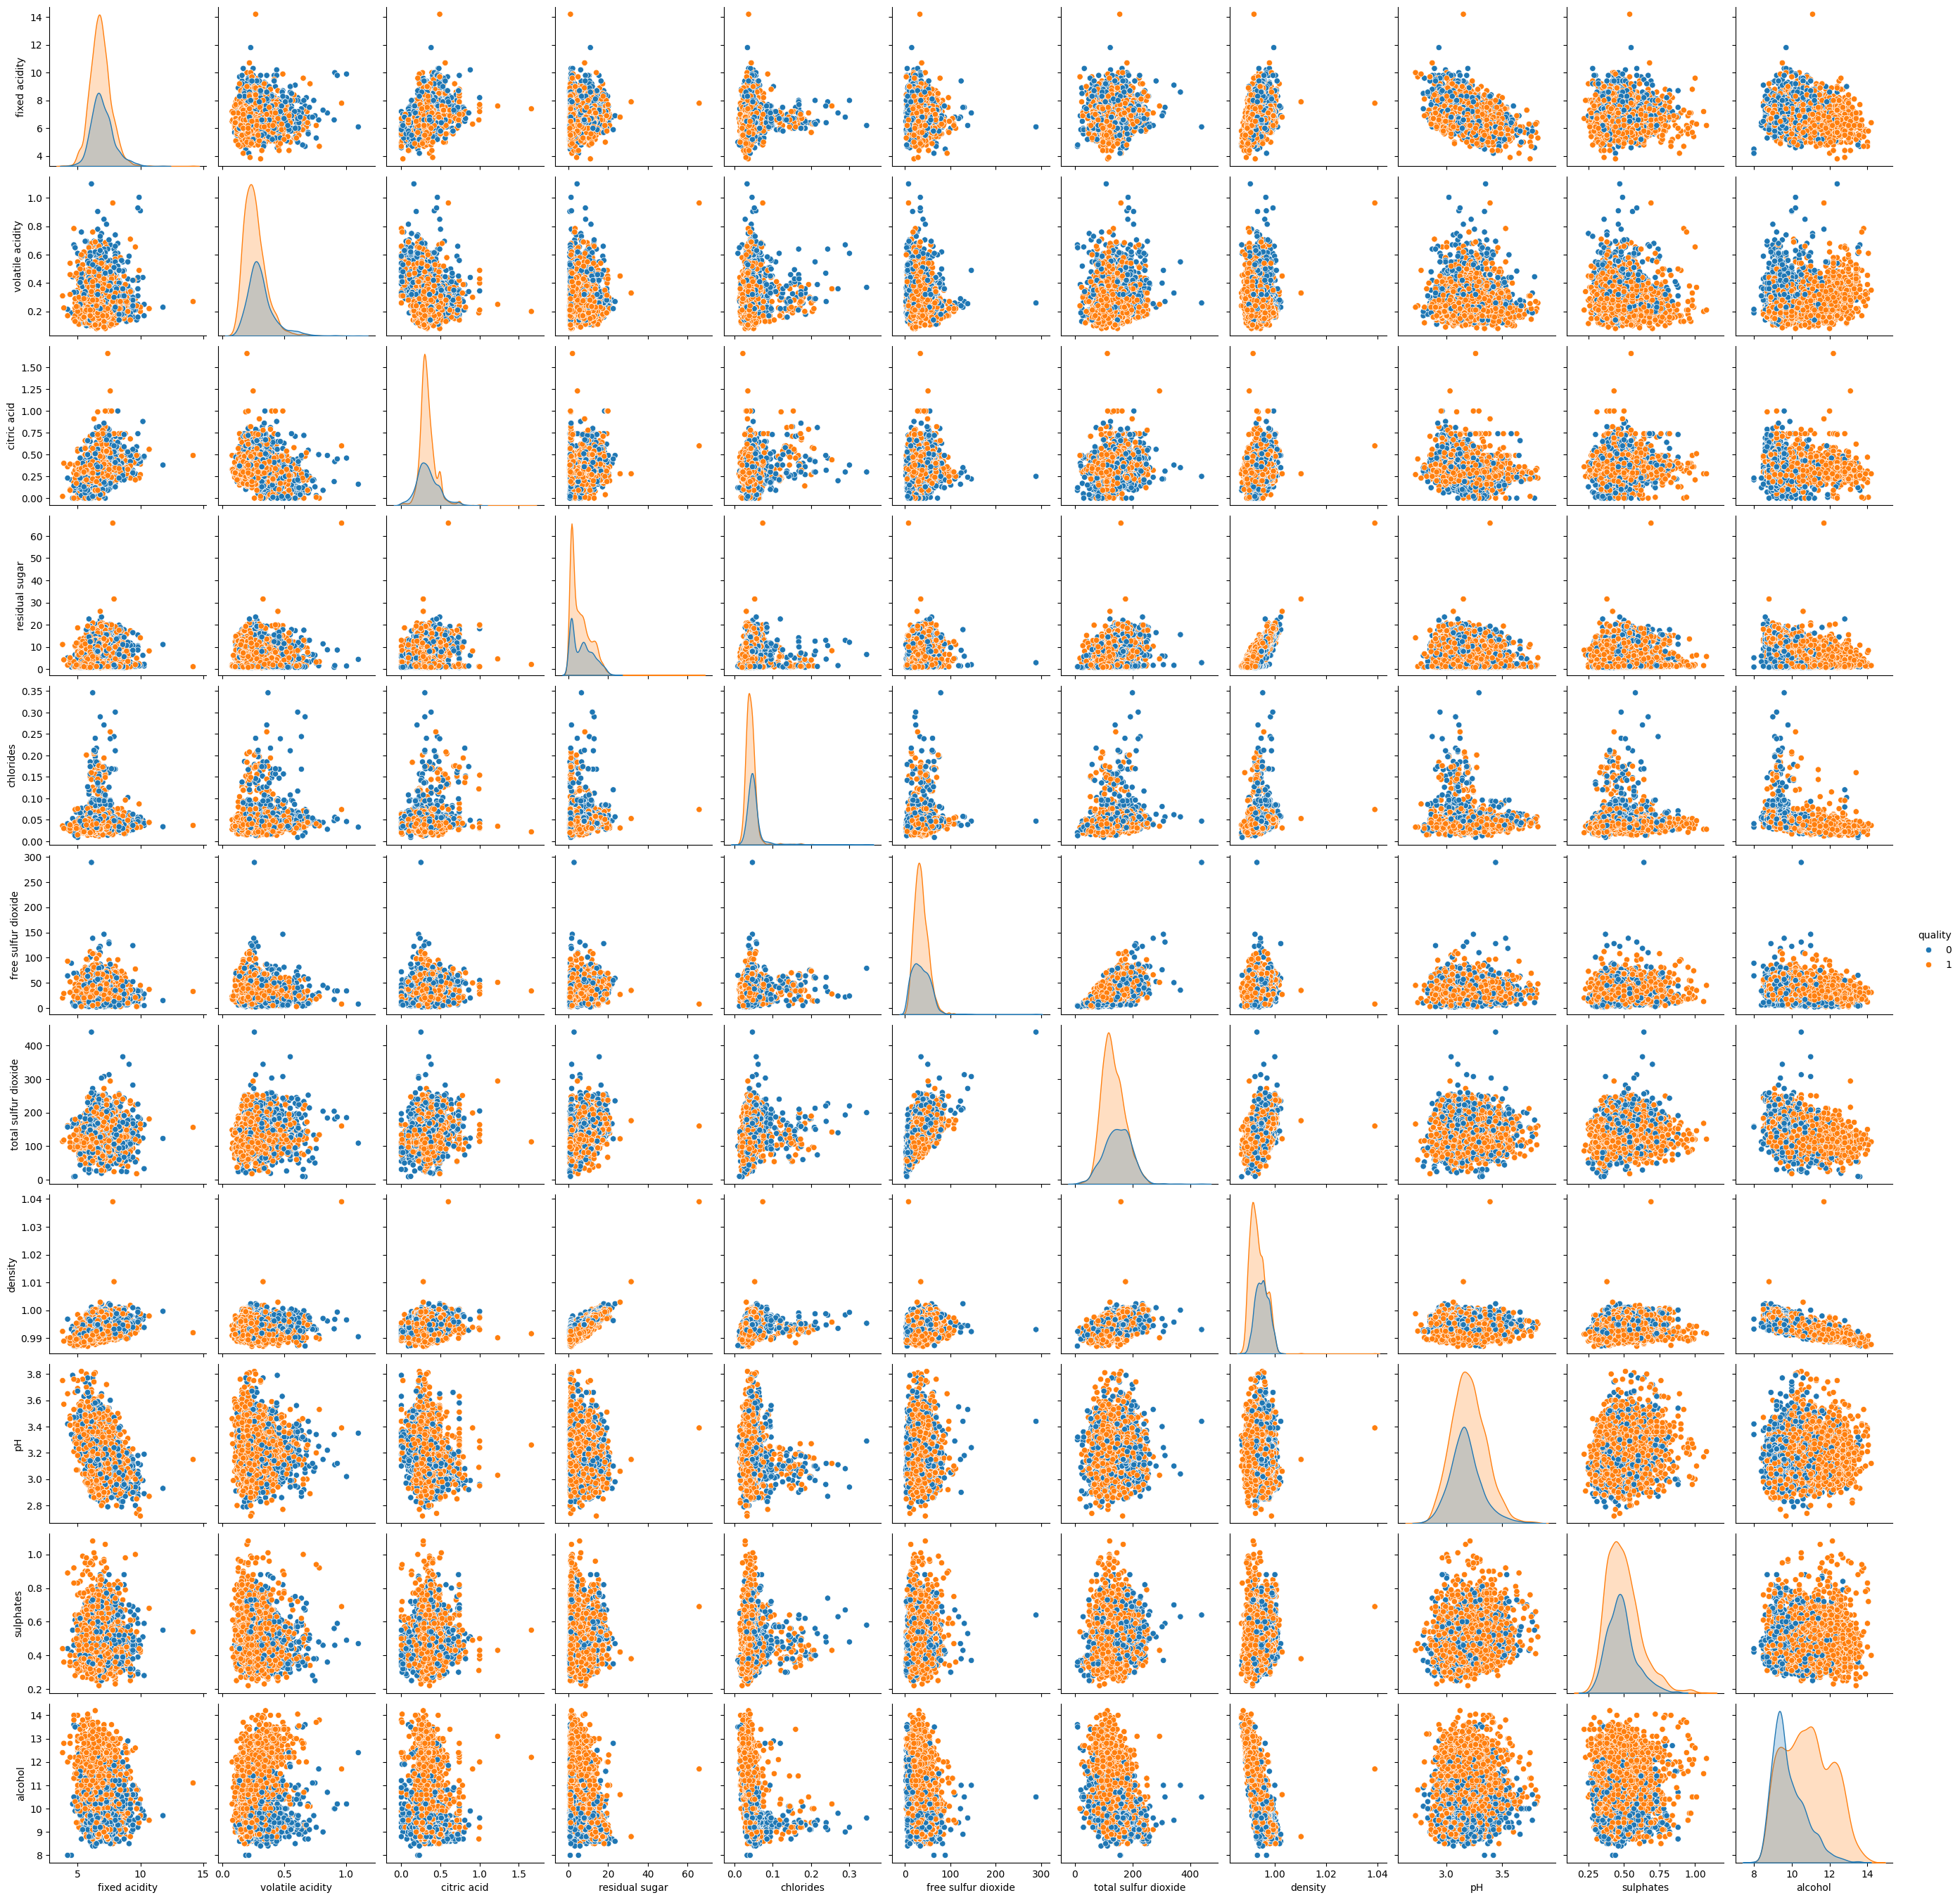

     k     Metric    Weight  Accuracy  F1 Score
7    5  manhattan  distance  0.835714  0.879220
13  11  euclidean  distance  0.834694  0.880707
15  11  manhattan  distance  0.833673  0.878810
9    9  euclidean  distance  0.831633  0.877506
11   9  manhattan  distance  0.826531  0.873512
5    5  euclidean  distance  0.823469  0.870218
2    1  manhattan   uniform  0.809184  0.858868
3    1  manhattan  distance  0.809184  0.858868
0    1  euclidean   uniform  0.804082  0.854545
1    1  euclidean  distance  0.804082  0.854545
6    5  manhattan   uniform  0.780612  0.840386
12  11  euclidean   uniform  0.769388  0.835756
4    5  euclidean   uniform  0.760204  0.825538
8    9  euclidean   uniform  0.760204  0.828342
14  11  manhattan   uniform  0.757143  0.825513
10   9  manhattan   uniform  0.754082  0.822924
Best Parameters: k=5, Metric=manhattan, Weight=distance
Final Accuracy: 0.8357
Final Precision: 0.8694
Final Recall: 0.8892
Final F1 Score: 0.8792
Confusion Matrix:
[[233  88]
 [ 73 58

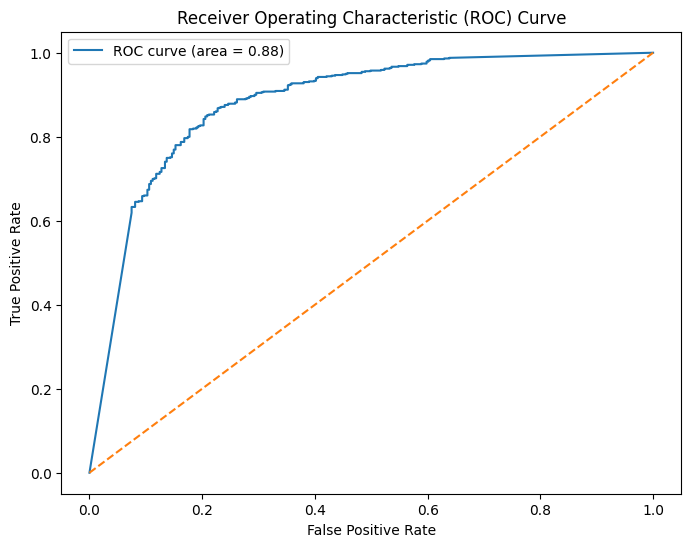

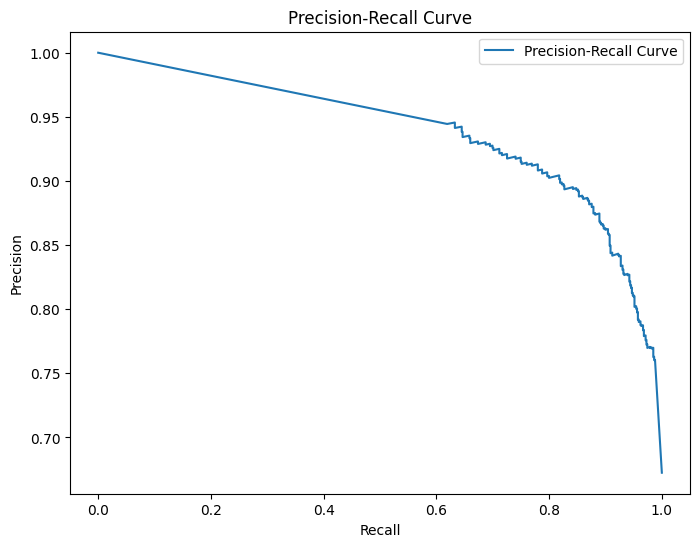

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

# Load dataset
df = pd.read_csv("winequality-white.csv", delimiter=";")

# Convert 'quality' column to binary classification
df['quality'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)

# Generate pair plots to identify redundant features
sns.pairplot(df, hue="quality")
plt.show()


# Partition function
def partition(X, y, t=0.2):
    """Splits data into training and testing sets based on given ratio t."""
    return train_test_split(X, y, test_size=t, random_state=42)

# Split data into features and target
X = df.drop(columns=['quality'])
y = df['quality']

# Split into training and test sets
X_train, X_test, y_train, y_test = partition(X, y, t=0.2)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning: Test different k values and distance metrics
k_values = [1, 5, 9, 11]
distance_metrics = ['euclidean', 'manhattan']
weights_options = ['uniform', 'distance']

results = []
for k in k_values:
    for metric in distance_metrics:
        for weight in weights_options:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weight)
            knn.fit(X_train_scaled, y_train)
            y_pred = knn.predict(X_test_scaled)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            results.append((k, metric, weight, acc, f1))

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results, columns=['k', 'Metric', 'Weight', 'Accuracy', 'F1 Score'])
print(results_df.sort_values(by='Accuracy', ascending=False))

# Train final KNN model with best parameters
best_k, best_metric, best_weight = results_df.sort_values(by='Accuracy', ascending=False).iloc[0][:3]
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, weights=best_weight)
knn_final.fit(X_train_scaled, y_train)
y_pred_final = knn_final.predict(X_test_scaled)

# Final Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
conf_matrix = confusion_matrix(y_test, y_pred_final)

# ROC Curve
y_scores = knn_final.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores)

# Display results
print(f'Best Parameters: k={best_k}, Metric={best_metric}, Weight={best_weight}')
print(f'Final Accuracy: {accuracy:.4f}')
print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
